<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">2018-2 · Máster universitario en Ciencia de datos (Data Science)</p>
<p style="margin: 0; text-align:right;">TFM · Sistema Reactivo Sobre Dispositivos IoT</p>
</div>
</div>
<div style="width:0%;">&nbsp;</div>


# TFM: Sistema Reactivo Sobre Dispositivos IoT - Parte I

Este notebook contiene la parte de analisis de los datos del trabajo realizado para el TFM.

################Análisis preliminar################

In [1]:
# carga de librerías necesarias:
%matplotlib inline
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from math import ceil
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Se carga el fichero con el conjunto de datos:
dataset = pd.read_excel("./datos/dataset_fecha_hora.xlsx", header=[0])

In [3]:
#Se muestran las cinco primeras filas del dataset:
dataset.head(5)

,WK_OF_YR,DIA,FECHA,HORA,TIPO_USER,ORDEN,ID_ACCION,ACCION,TIPO_DIA
0,52,DOM,01/01/2017,08:31:00,USER_1,1,28,Sube la persiana de la habitación,WKN
1,52,DOM,01/01/2017,09:02:00,USER_1,2,29,Sube la persiana del salón,WKN
2,52,DOM,01/01/2017,09:02:00,USER_1,3,20,Enciende Radio3,WKN
3,52,DOM,01/01/2017,09:17:00,USER_1,4,11,Dame el parte de tiempo,WKN
4,52,DOM,01/01/2017,11:01:00,USER_1,5,3,Apaga la radio,WKN


In [4]:
#Se muestran las cinco últimas filas del dataset:
dataset.tail(5)

,WK_OF_YR,DIA,FECHA,HORA,TIPO_USER,ORDEN,ID_ACCION,ACCION,TIPO_DIA
30474,1,LUN,31/12/2018,20:02:00,USER_3,13,2,Apaga la luz de la habitación,SEM
30475,1,LUN,31/12/2018,20:06:00,USER_3,14,8,Baja la persiana de la habitación,SEM
30476,1,LUN,31/12/2018,20:22:00,USER_3,15,19,Enciende la televisión,SEM
30477,1,LUN,31/12/2018,23:31:00,USER_3,16,26,Programa el despertador para las 7:40,SEM
30478,1,LUN,31/12/2018,23:38:00,USER_3,17,5,Apaga la televisión,SEM


In [5]:
#Se muestra la información del dataset:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30479 entries, 0 to 30478
Data columns (total 9 columns):
WK_OF_YR     30479 non-null int64
DIA          30479 non-null object
FECHA        30479 non-null object
HORA         30479 non-null object
TIPO_USER    30479 non-null object
ORDEN        30479 non-null int64
ID_ACCION    30479 non-null int64
ACCION       30479 non-null object
TIPO_DIA     30479 non-null object
dtypes: int64(3), object(6)
memory usage: 2.1+ MB


In [6]:
#mostramos los diferentes valores de TIPO_DIA
for valor in dataset['TIPO_DIA'].unique():
    print(valor)

WKN
SEM


In [7]:
#mostramos los diferentes valores de TIPO_USER
for valor in dataset['TIPO_USER'].unique():
    print(valor)

USER_1
USER_2
USER_3


In [8]:
#se obtienen y exportan las diferentes acciones con su identificador 
df_accion = dataset.groupby(['ID_ACCION','ACCION']).size().reset_index(name='FREC')

#print(df_accion)

df_accion.to_excel("./datos/dataset_acciones.xlsx",
                  columns = ['ID_ACCION','ACCION'],
                  engine='xlsxwriter')

################Limpieza básica################

In [9]:
#Se establecen los tipos de datos para las columnas en que es necesario:
dataset['FECHA'] = pd.to_datetime(dataset['FECHA'])
dataset['HORA'] = pd.to_timedelta(dataset['HORA'])

In [10]:
#definimos una función para convertir horas y minutos en números enteros
def timedelta_to_min(time):
    hora_min = (time.components.hours*60) + time.components.minutes
    return hora_min

#Se agrega una columna con las horas en formato minutos
dataset['HORA_MIN'] = [timedelta_to_min(hora) for hora in dataset['HORA']]

In [11]:
#se definen dos columnas para codificar las variables categóricas como enteros
convers_int = {"TIPO_USER_INT": {"USER_1": 1, "USER_2": 2, "USER_3": 3},
               "TIPO_DIA_INT": {"SEM": 0, "WKN": 1}}

#se replican las columnas y se codifican como enteros
dataset['TIPO_USER_INT'] = [tipo_user for tipo_user in dataset['TIPO_USER']]
dataset['TIPO_DIA_INT'] = [tipo_dia for tipo_dia in dataset['TIPO_DIA']]

dataset.replace(convers_int, inplace=True)

In [12]:
#añadimos una columna con una conversión de minutos a intervalos de X minutos (lo establecemos en 10 minutos)
INTERVALO = 10
dataset['HORA_NORM'] = [ceil(hora_min/INTERVALO) for hora_min in dataset['HORA_MIN']]

In [13]:
#Se seleccionan las columnas con las que se va a trabajar:
df_train = dataset[['HORA','HORA_MIN','HORA_NORM','TIPO_USER','TIPO_USER_INT','ID_ACCION','TIPO_DIA','TIPO_DIA_INT']]

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30479 entries, 0 to 30478
Data columns (total 8 columns):
HORA             30479 non-null timedelta64[ns]
HORA_MIN         30479 non-null int64
HORA_NORM        30479 non-null int64
TIPO_USER        30479 non-null object
TIPO_USER_INT    30479 non-null int64
ID_ACCION        30479 non-null int64
TIPO_DIA         30479 non-null object
TIPO_DIA_INT     30479 non-null int64
dtypes: int64(5), object(2), timedelta64[ns](1)
memory usage: 1.9+ MB


In [14]:
#Se muestran las cinco primeras filas del dataset:
df_train.head(5)

,HORA,HORA_MIN,HORA_NORM,TIPO_USER,TIPO_USER_INT,ID_ACCION,TIPO_DIA,TIPO_DIA_INT
0,08:31:00,511,52,USER_1,1,28,WKN,1
1,09:02:00,542,55,USER_1,1,29,WKN,1
2,09:02:00,542,55,USER_1,1,20,WKN,1
3,09:17:00,557,56,USER_1,1,11,WKN,1
4,11:01:00,661,67,USER_1,1,3,WKN,1


In [15]:
#se exporta el datset preparado para el análisis
df_train.to_excel("./datos/dataset_fecha_hora_clean.xlsx",
                  columns = ['HORA','HORA_MIN','HORA_NORM','TIPO_USER','TIPO_USER_INT','ID_ACCION','TIPO_DIA','TIPO_DIA_INT'],
                  engine='xlsxwriter')

################Análisis de variables################

In [16]:
#se muestra un resumen estadístico de la variable hora
df_train['HORA_MIN'].describe()

count    30479.000000
mean       840.714984
std        355.475267
min        405.000000
25%        511.000000
50%        735.000000
75%       1216.000000
max       1419.000000
Name: HORA_MIN, dtype: float64

In [17]:
#configuración de la apariencia de sns
sns.set();

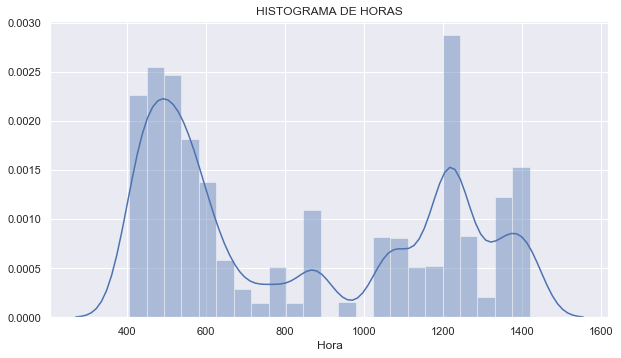

In [18]:
#histograma para HORA_MIN
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)

sns.distplot(df_train['HORA_MIN'], ax=ax1)

plt.title('HISTOGRAMA DE HORAS')
plt.xlabel("Hora")

plt.show()

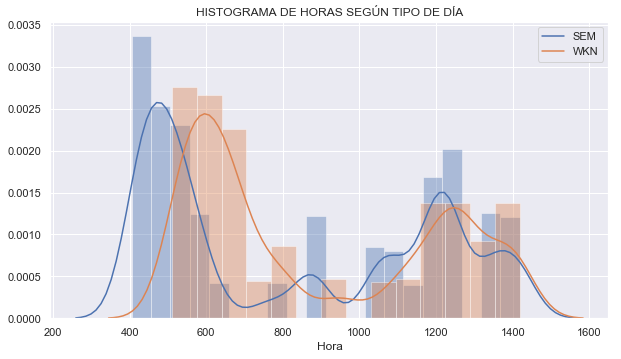

In [19]:
# representamos un histograma de HORA_MIN según el valor de TIPO_DIA
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)

# representamos los datos de SEM
sns.distplot(df_train.loc[df_train['TIPO_DIA'] == 'SEM']['HORA_MIN'], ax=ax1, kde_kws={"label": "SEM"})

# representamos los datos de WKN en el mismo gráfico
sns.distplot(df_train.loc[df_train['TIPO_DIA'] == 'WKN']['HORA_MIN'], ax=ax1, kde_kws={"label": "WKN"})

plt.title('HISTOGRAMA DE HORAS SEGÚN TIPO DE DÍA')
plt.xlabel("Hora")

plt.show()

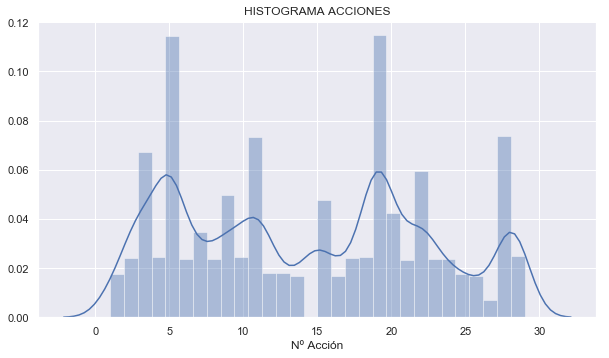

In [20]:
# Histograma de acciones
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)

sns.distplot(df_train['ID_ACCION'], ax=ax1).set_title('HISTOGRAMA ACCIONES')

plt.title('HISTOGRAMA ACCIONES')
plt.xlabel("Nº Acción")

plt.show()

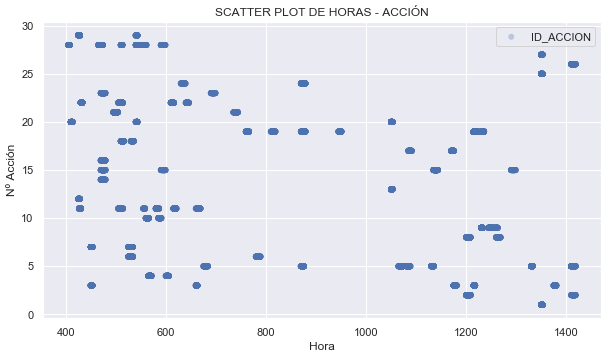

In [21]:
#Scatter plot de HORAS-ACCION
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)

# generamos un conjunto de datos para el scatter
d1 = df_train[['ID_ACCION','HORA_MIN']]

ax1.scatter(d1['HORA_MIN'], d1['ID_ACCION'], alpha=0.3, edgecolors='none')

ax1.legend(loc='best')
ax1.grid(True)

plt.title('SCATTER PLOT DE HORAS - ACCIÓN')
plt.xlabel("Hora")
plt.ylabel("Nº Acción")

plt.show()

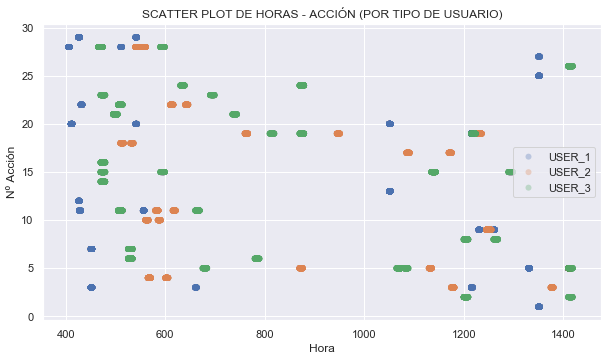

In [22]:
#Scatter Plot de HORAS-ACCION por TIPO_USER
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)

# generamos tres conjuntos de datos, uno por cada usuario
d1 = df_train.loc[df_train['TIPO_USER'] == 'USER_1'][['ID_ACCION','HORA_MIN']]
d2 = df_train.loc[df_train['TIPO_USER'] == 'USER_2'][['ID_ACCION','HORA_MIN']]
d3 = df_train.loc[df_train['TIPO_USER'] == 'USER_3'][['ID_ACCION','HORA_MIN']]

ax1.scatter(d1['HORA_MIN'], d1['ID_ACCION'], label='USER_1', alpha=0.3, edgecolors='none')
ax1.scatter(d2['HORA_MIN'], d2['ID_ACCION'], label='USER_2', alpha=0.3, edgecolors='none')
ax1.scatter(d3['HORA_MIN'], d3['ID_ACCION'], label='USER_3', alpha=0.3, edgecolors='none')

ax1.legend(loc='best')
ax1.grid(True)

plt.title('SCATTER PLOT DE HORAS - ACCIÓN (POR TIPO DE USUARIO)')
plt.xlabel("Hora")
plt.ylabel("Nº Acción")

plt.show()

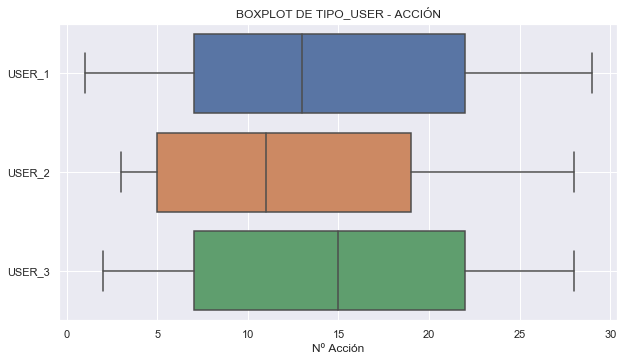

In [23]:
#Histograma de TIPO_USER-ACCION
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)

sns.boxplot(df_train['ID_ACCION'], df_train['TIPO_USER'], ax=ax1)
ax1.grid(True)

plt.title('BOXPLOT DE TIPO_USER - ACCIÓN')
plt.xlabel("Nº Acción")
plt.ylabel("")

plt.show()

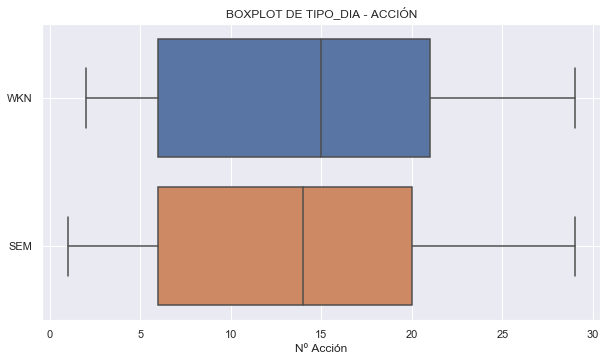

In [24]:
#Histograma de TIPO_USER-ACCION
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)

sns.boxplot(df_train['ID_ACCION'], df_train['TIPO_DIA'], ax=ax1)
ax1.grid(True)

plt.title('BOXPLOT DE TIPO_DIA - ACCIÓN')
plt.xlabel("Nº Acción")
plt.ylabel("")

plt.show()

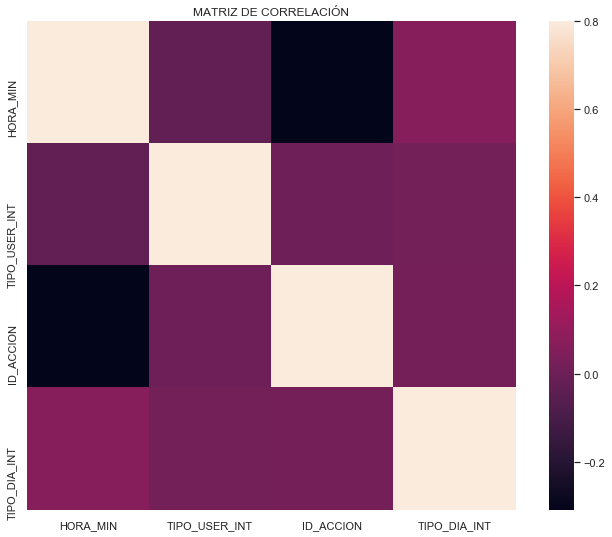

In [25]:
# Matriz de correlación
f, ax1 = plt.subplots(figsize=(12, 9))

corr_mat = df_train[['HORA_MIN','TIPO_USER_INT','ID_ACCION','TIPO_DIA_INT']].corr()
sns.heatmap(corr_mat, vmax=.8, square=True);
ax1.grid(True)

plt.title('MATRIZ DE CORRELACIÓN')

plt.show()